In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import glob
import PIL
from PIL import Image
import imageio
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pathlib

In [3]:
train_dir = pathlib.Path('/content/drive/MyDrive/TumorDetection/Dataset/train')
val_dir = pathlib.Path('/content/drive/MyDrive/TumorDetection/Dataset/val')
test_dir = pathlib.Path('/content/drive/MyDrive/TumorDetection/Dataset/test')

image_count_train = len(list(train_dir.glob('*/*.jpg')))
image_count_val = len(list(val_dir.glob('*/*.jpg')))
image_count_test = len(list(test_dir.glob('*/*.jpg')))
print("Train Image Count: {} \n Val Image Count: {} \n Test Image Count: {}".format(image_count_train,image_count_val,image_count_test))

Train Image Count: 2400 
 Val Image Count: 300 
 Test Image Count: 300


In [4]:
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils

def load_data(dir_path, img_size=(100, 100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            sub_dir_path = os.path.join(dir_path, path)  # Construct full sub-directory path
            for file in os.listdir(sub_dir_path):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(sub_dir_path, file))  # Construct full file path
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

IMG_SIZE = (224,224)
X_train, y_train, labels = load_data(train_dir, IMG_SIZE)
X_test, y_test, _ = load_data(test_dir, IMG_SIZE)
X_val, y_val, _ = load_data(val_dir, IMG_SIZE)

100%|██████████| 2/2 [00:30<00:00, 15.16s/it]
<ipython-input-4-3c1ed7ae85fc>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


2400 images loaded from /content/drive/MyDrive/TumorDetection/Dataset/train directory.


100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


300 images loaded from /content/drive/MyDrive/TumorDetection/Dataset/test directory.


100%|██████████| 2/2 [00:03<00:00,  1.67s/it]

300 images loaded from /content/drive/MyDrive/TumorDetection/Dataset/val directory.


In [5]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [6]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

<ipython-input-5-65876982ba26>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(set_new)


In [7]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [8]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [9]:
update_train_dir = pathlib.Path('/content/TRAIN_CROP')
update_val_dir = pathlib.Path('/content/VAL_CROP')
update_test_dir = pathlib.Path('/content/TEST_CROP')

In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    update_train_dir,
    validation_split=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2400 files belonging to 2 classes.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    update_val_dir,
    validation_split=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 300 files belonging to 2 classes.


In [13]:
class_names = train_ds.class_names
print(class_names)

['NO', 'YES']


In [14]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(255, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


# Define the EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=4,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

hist=model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

Epoch 1/10
75/75 [==============================] - 74s 972ms/step - loss: 0.6443 - accuracy: 0.6637 - val_loss: 0.5222 - val_accuracy: 0.7600
Epoch 2/10
75/75 [==============================] - 70s 935ms/step - loss: 0.4005 - accuracy: 0.8279 - val_loss: 0.3443 - val_accuracy: 0.8867
Epoch 3/10
75/75 [==============================] - 71s 943ms/step - loss: 0.2497 - accuracy: 0.8992 - val_loss: 0.2621 - val_accuracy: 0.9000
Epoch 4/10
75/75 [==============================] - 70s 935ms/step - loss: 0.1366 - accuracy: 0.9538 - val_loss: 0.1993 - val_accuracy: 0.9333
Epoch 5/10
75/75 [==============================] - 73s 978ms/step - loss: 0.0984 - accuracy: 0.9658 - val_loss: 0.1995 - val_accuracy: 0.9267
Epoch 6/10
75/75 [==============================] - 72s 947ms/step - loss: 0.1074 - accuracy: 0.9604 - val_loss: 0.4577 - val_accuracy: 0.8367
Epoch 7/10
75/75 [==============================] - 70s 930ms/step - loss: 0.0888 - accuracy: 0.9646 - val_loss: 0.3346 - val_accuracy: 0.8767

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 32)       

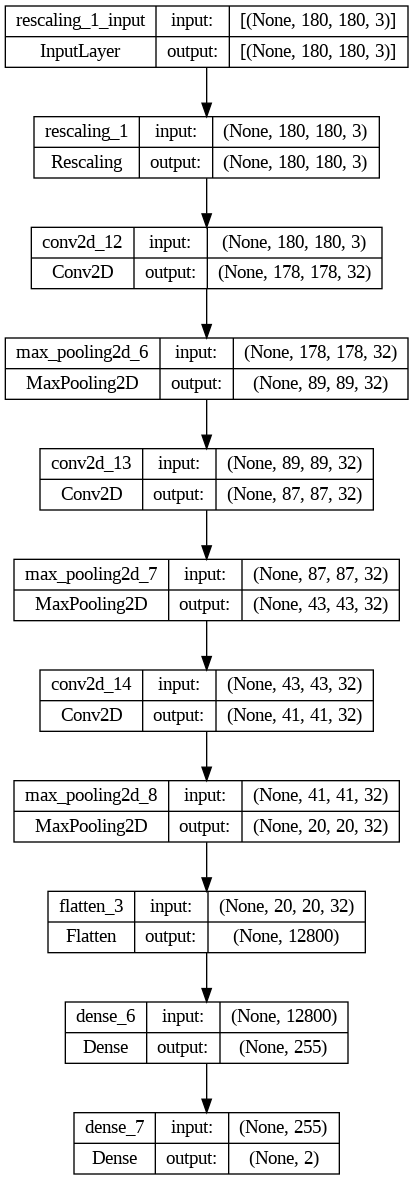

In [21]:
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          expand_nested=True)

In [22]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    try:
      name = metric.replace("_"," ").capitalize()
      plt.plot(history.epoch, history.history[metric], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      else:
        plt.ylim([0,1])
      plt.legend()
      plt.show()
    except:
      pass

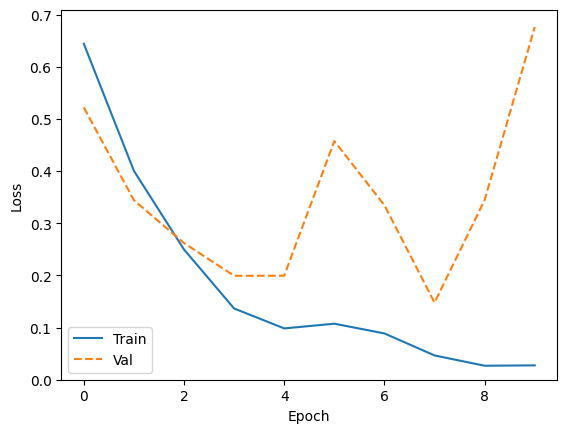

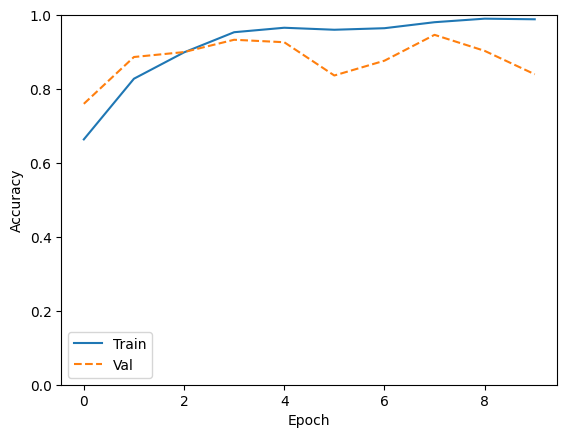

In [23]:
plot_metrics(hist)

In [24]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    update_test_dir,
    validation_split=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

#test_samples = test_ds.cardinality().numpy()

Found 300 files belonging to 2 classes.


In [26]:
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

10/10 [==============================] - 2s 199ms/step


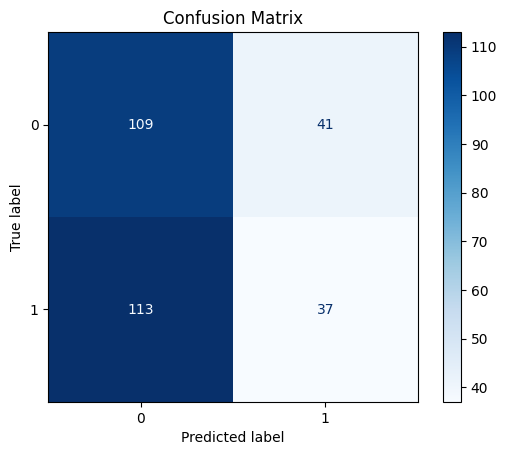

Accuracy: 0.4867


In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # Extract true labels from the test dataset

accuracy = accuracy_score(true_labels, predicted_labels)

confusion = confusion_matrix(true_labels, predicted_labels)
class_labels = [str(label) for label in range(num_classes)]  # Assuming classes are numbered from 0 to num_classes-1

confusion_display = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=class_labels)
confusion_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {accuracy:.4f}")